In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import random

# Step 1: Load and Explore the Dataset

In [111]:
df_ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [112]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [113]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [114]:
df_movies = pd.read_csv("ml-latest-small/movies.csv")

In [115]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


# Step 2: Analyze the Sparsity of the Rating Matrix

#### Construct a user-item interaction matrix where rows represent users and columns represent movies, with ratings as values.

In [116]:
df_pivot = df_ratings.pivot(index="userId", columns="movieId", values="rating")
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Columns: 9724 entries, 1 to 193609
dtypes: float64(9724)
memory usage: 45.3 MB


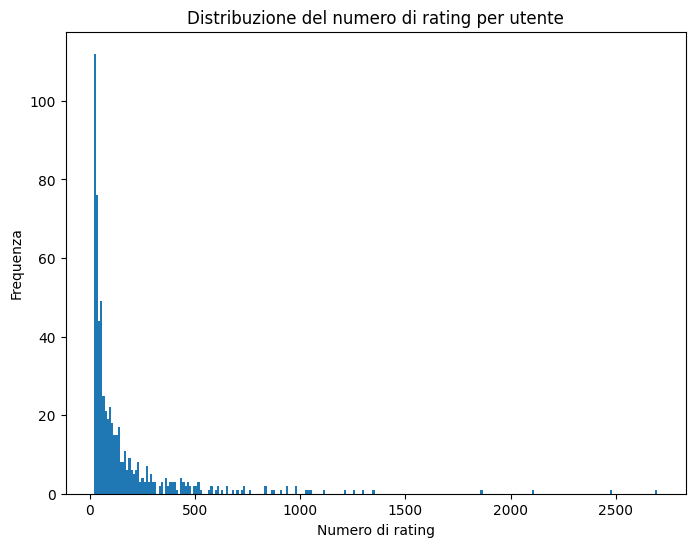

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64


In [151]:
# Contare il numero di rating effettuati da ciascun utente
ratings_per_user = df_pivot.notna().sum(axis=1)

plt.figure(figsize=(8, 6))
plt.hist(ratings_per_user, bins=len(ratings_per_user.unique()))
plt.title('Distribuzione del numero di rating per utente')
plt.xlabel('Numero di rating')
plt.ylabel('Frequenza')
plt.show()

print(ratings_per_user.describe())

####  Compute the sparsity of the matrix:

In [117]:
num_of_ratings = len(df_ratings)
user_movie_pairs = len(df_ratings)*len(df_movies)
sparsity = 1 - num_of_ratings/user_movie_pairs
sparsity

0.9998973516731677

# Step 3: Handle Missing Values

#### Identify movies and users with the most missing ratings.

In [118]:
# Conta i valori mancanti (NaN) per ogni film
missing_by_movie = df_pivot.isna().sum().sort_values(ascending=False)

# Converte gli ID in titoli usando movie_dict
movie_dict = pd.Series(df_movies.title.values, index=df_movies.movieId).to_dict()
missing_by_movie.index = missing_by_movie.index.map(movie_dict)

# Mostra i film con più rating mancanti
print(missing_by_movie.head(10))

movieId
Andrew Dice Clay: Dice Rules (1991)                     609
Drained (O cheiro do Ralo) (2006)                       609
Everlasting Piece, An (2000)                            609
Signal, The (2007)                                      609
Untraceable (2008)                                      609
First Sunday (2008)                                     609
Cat Soup (Nekojiru-so) (2001)                           609
Heaven and Earth (Ten to Chi to) (1990)                 609
Hatchet (2006)                                          609
In the Name of the King: A Dungeon Siege Tale (2008)    609
dtype: int64


In [119]:
# Conta i valori mancanti per ogni utente
missing_by_user = df_pivot.isna().sum(axis=1).sort_values(ascending=False)

# Mostra gli utenti con più rating mancanti
print(missing_by_user.head(10))

userId
595    9704
207    9704
406    9704
189    9704
442    9704
194    9704
278    9704
569    9704
147    9704
257    9704
dtype: int64


#### Apply simple missing value imputation techniques:
- Fill missing ratings with the movie’s average rating.

In [120]:
# Calcola la media di ogni film (colonne)
movie_avg = df_pivot.mean(axis=0)

# Riempie i valori NaN con la media del film
df_movie_avg_filled = df_pivot.apply(lambda col: col.fillna(movie_avg[col.name]), axis=0)

✅ Pro:

Tiene conto delle caratteristiche specifiche del film.
Funziona bene se i film hanno ricevuto un numero decente di valutazioni.

❌ Contro:

I film poco recensiti rischiano di avere una media poco rappresentativa.
Se un film non ha nessuna valutazione, rimane comunque un NaN.
Non considera le preferenze individuali degli utenti.

💡 Quando usarlo: Quando i film hanno abbastanza recensioni e vuoi mantenere una visione orientata al contenuto.

- Fill missing ratings with the user’s average rating.

In [121]:
# Calcola la media di ogni utente (righe)
user_avg = df_pivot.mean(axis=1)

# Riempie i valori NaN con la media dell'utente
df_user_avg_filled = df_pivot.apply(lambda row: row.fillna(user_avg[row.name]), axis=1)

✅ Pro:

Tiene conto delle preferenze personali di ciascun utente.
È utile se alcuni utenti tendono a dare voti sempre alti o sempre bassi.

❌ Contro:

Non considera la qualità o popolarità del film, solo il comportamento dell'utente.
Se un utente ha valutato pochissimi film, la sua media potrebbe non essere significativa.

💡 Quando usarlo: Quando gli utenti hanno pattern di valutazione chiari (es. qualcuno vota sempre severo, qualcun altro sempre generoso).

- Fill missing ratings with the global average rating.

In [122]:
# Calcola la media globale
global_avg = df_pivot.stack().mean() 

# Riempie i NaN con la media globale
df_global_avg_filled = df_pivot.fillna(global_avg)

✅ Pro:

È semplice e veloce da applicare.
Non lascia buchi: tutti i NaN vengono riempiti.

❌ Contro:

È molto generico: ignora sia le preferenze dell'utente che la popolarità/qualità del film.
Può introdurre bias: se molti film hanno rating molto diversi dalla media globale, questa approssimazione è debole.

💡 Quando usarlo: Quando hai molti valori mancanti e hai bisogno di un’imputazione di base, magari come punto di partenza per tecniche più avanzate.

In [123]:
chosen_df_filled = df_user_avg_filled

# Step 4: Week 2

#### Identify which kind of rating you have in the dataset

Uniques:  [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]

Stats: 	 count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


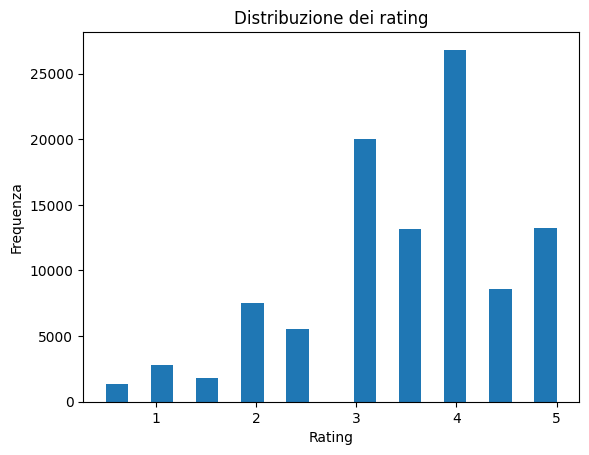

In [124]:
# Valori unici dei rating
print("Uniques: ", df_ratings['rating'].unique())

# Statistiche di base
print("\nStats: \t", df_ratings['rating'].describe())

# Distribuzione dei rating
plt.hist(df_ratings['rating'], bins=20)
plt.title('Distribuzione dei rating')
plt.xlabel('Rating')
plt.ylabel('Frequenza')
plt.show()

#### Verify the ratings have a long tail distribution

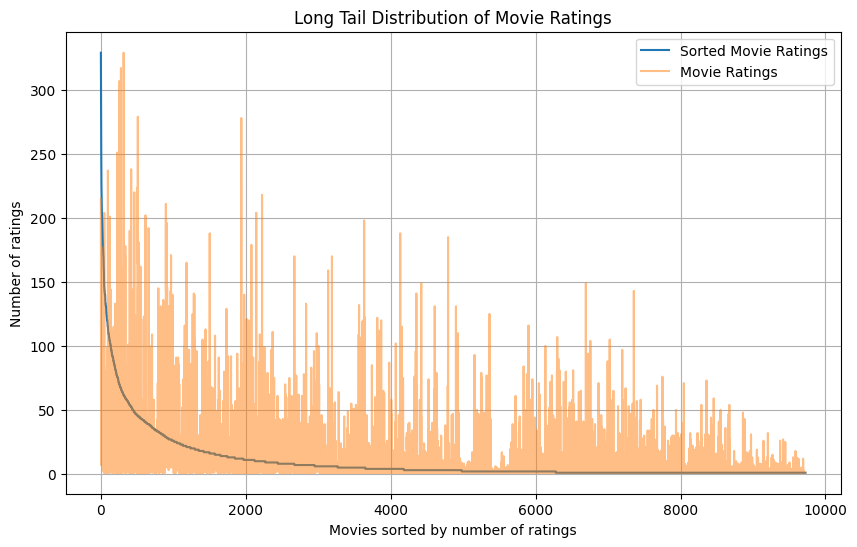

In [125]:
ratings_per_movie = df_pivot.count()

plt.figure(figsize=(10, 6))

plt.plot(ratings_per_movie.sort_values(ascending=False).values, label='Sorted Movie Ratings')
plt.plot(ratings_per_movie.values, alpha=0.5, label="Movie Ratings")

plt.xlabel("Movies sorted by number of ratings")
plt.ylabel("Number of ratings")
plt.title("Long Tail Distribution of Movie Ratings")
plt.legend()
plt.grid(True)
plt.show()

#### Implement a Neighbourhood Based Collaborative Filtering exploiting a user based approach to identify the neighborhood.

#### 1. Pearson Coefficient

In [126]:
# Creiamo una lista di tuple (user_1, user_2, pearson_corr)
correlations = []

# Lista di utenti
users = chosen_df_filled.index

# Ciclo su tutte le coppie di utenti
for i in range(len(users)):
    for j in range(i + 1, len(users)):
        user_1 = df_pivot.loc[users[i]]
        user_2 = df_pivot.loc[users[j]]

        # Trova i film valutati da entrambi
        common_movies = user_1.notna() & user_2.notna()
        ratings_1 = user_1[common_movies]
        ratings_2 = user_2[common_movies]

        # Calcola Pearson solo se ci sono almeno due valutazioni comuni
        if len(ratings_1) > 1:
            correlation, _ = pearsonr(ratings_1, ratings_2)
        else:
            correlation = None

        # Aggiungi il risultato
        correlations.append((users[i], users[j], correlation))

# Creiamo un DataFrame con le correlazioni
df_pearson = pd.DataFrame(correlations, columns=["user_1", "user_2", "pearson_corr"])

/tmp/ipykernel_138019/624115338.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(ratings_1, ratings_2)


🔗 Why Pearson Correlation was not used:

- <b>Problemi con dati costanti:</b> come hai visto col warning `ConstantInputWarning`, se uno degli utenti ha varianza zero (ad esempio ha dato sempre lo stesso voto), Pearson non è definito. Questo è comune nei sistemi di raccomandazione con utenti che valutano pochi item.

#### 2. Cosine Similarity

In [127]:
# Calcolare la similarità del coseno tra gli utenti
user_similarity = cosine_similarity(chosen_df_filled)
# Creare un DataFrame di similarità
user_similarity_df = pd.DataFrame(user_similarity, index=chosen_df_filled.index, columns=chosen_df_filled.index)
print("Similarità tra utenti:\n", user_similarity_df)

Similarità tra utenti:
 userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.999542  0.998167  0.998170  0.999449  0.998593  0.998280   
2       0.999542  1.000000  0.998504  0.998423  0.999780  0.998977  0.998621   
3       0.998167  0.998504  1.000000  0.997026  0.998369  0.997624  0.997253   
4       0.998170  0.998423  0.997026  1.000000  0.998300  0.997575  0.997346   
5       0.999449  0.999780  0.998369  0.998300  1.000000  0.998891  0.998533   
...          ...       ...       ...       ...       ...       ...       ...   
606     0.997387  0.997707  0.996196  0.996334  0.997630  0.996785  0.996549   
607     0.999035  0.999311  0.997928  0.997901  0.999235  0.998496  0.998122   
608     0.994793  0.994911  0.993479  0.993272  0.994811  0.994124  0.993817   
609     0.999560  0.999899  0.998529  0.998450  0.999815  0.999032  0.998656   
610     0.996034

📐 Cosine Similarity:

- Misura l'angolo tra i vettori, non la distanza. In termini di raccomandazioni, ogni utente è un vettore di rating, e cosine si concentra sulla direzione piuttosto che sulla magnitudine.
- Resistente alle scale diverse: se due utenti danno rating simili ma uno tende a dare voti più alti di default, la cosine similarity li considera comunque simili.
- Funziona bene anche con molti valori mancanti: quando ci sono molti NaN (come accade nei sistemi di raccomandazione), la cosine similarity riesce comunque a cogliere pattern di somiglianza anche su pochi item comuni.

#### 💡 Quando preferire cosine similarity:

- Quando hai dati molto sparsi (molti NaN) — cosa molto comune nei sistemi di raccomandazione.
- Quando ti interessa la similarità nella “forma” dei rating, più che nelle differenze assolute.
- Quando vuoi evitare problemi di varianza zero.

#### 🔍 Quando usare Pearson:

- Se sai che i dati sono ben distribuiti e senza troppi valori mancanti.
- Quando vuoi normalizzare la tendenza di ciascun utente (es. un utente che vota sempre alto vs. uno che vota sempre basso, anche se concordano nei pattern).

In [142]:
def predict_rating(utente_target, film_target, user_similarity_df=user_similarity_df):
    if utente_target not in chosen_df_filled.index:
        raise ValueError(f"L'utente {utente_target} non esiste nel dataset.")
    if film_target not in chosen_df_filled.columns:
        raise ValueError(f"Il film {film_target} non esiste nel dataset.")

    # Ordinare gli utenti in base alla similarità (escludendo l'utente stesso)
    neighborhood = user_similarity_df[utente_target].drop(utente_target).sort_values(ascending=False)
    print(f"\nVicinato dei 5 utenti di [{utente_target}]:\n", neighborhood[:5])

    # Prendere solo i rating dei vicini per quel film
    ratings_from_neighbors = chosen_df_filled.loc[neighborhood.index, film_target]

    # Ponderare i rating in base alla similarità
    weighted_sum = sum(rating * neighborhood[utente] for utente, rating in ratings_from_neighbors.items())
    similarity_sum = sum(neighborhood[utente] for utente in ratings_from_neighbors.index)

    # Previsione del rating (evitare divisione per 0)
    if similarity_sum != 0:
        predicted_rating = weighted_sum / similarity_sum
    else:
        predicted_rating = np.nan

    print(f"\nRating previsto per utente [{utente_target}] su {movie_dict[film_target]}: {predicted_rating:.2f}")

In [143]:
chosen_user = random.choice(chosen_df_filled.index)
chosen_film = random.choice(chosen_df_filled.columns)

predict_rating(chosen_user, chosen_film, user_similarity_df)


Vicinato dei 5 utenti di [385]:
 userId
440    0.999328
53     0.999315
72     0.999315
118    0.999313
515    0.999313
Name: 385, dtype: float64

Rating previsto per utente [385] su April Morning (1988): 3.66


####  Handle the personal bias by weighting the rating data present in the dataset

In [144]:
# Centrare i dati sottraendo la media dei rating per ogni utente
user_means = chosen_df_filled.mean(axis=1)
df_centered = chosen_df_filled.sub(user_means, axis=0)

# Ricalcolare la similarità del coseno sui dati centrati
user_similarity = cosine_similarity(df_centered)
user_similarity_no_bias_df = pd.DataFrame(user_similarity, index=chosen_df_filled.index, columns=chosen_df_filled.index)

In [145]:
predict_rating(chosen_user, chosen_film, user_similarity_no_bias_df)


Vicinato dei 5 utenti di [385]:
 userId
266    0.168142
229    0.166996
304    0.165835
434    0.164360
199    0.163569
Name: 385, dtype: float64

Rating previsto per utente [385] su April Morning (1988): 3.61


#### Apply a Discount Factor in the calculation of similarity

In [155]:
# Conteggio degli item in comune tra due utenti
common_items_count = df_pivot.notna().astype(int).dot(df_pivot.notna().astype(int).T)

# Discount factor: più bassa è la sovrapposizione, più forte è lo sconto
min_common_items = 15  # Visto che minimo un utente ha recensito 20 film, scelto 15 come n# film comuni
discount_factor = common_items_count / (common_items_count + min_common_items)

# Applicare il discount factor alla similarità
user_similarity_discounted = user_similarity_no_bias_df * discount_factor
user_similarity_discounted_df = pd.DataFrame(user_similarity_discounted, index=chosen_df_filled.index, columns=chosen_df_filled.index)

In [156]:
predict_rating(chosen_user, chosen_film, user_similarity_discounted_df)


Vicinato dei 5 utenti di [385]:
 userId
304    0.137243
199    0.132900
266    0.131589
434    0.127005
202    0.126683
Name: 385, dtype: float64

Rating previsto per utente [385] su April Morning (1988): 3.58


####  Integrate a strategy to handle the Long Tail Problem

L'approccio "Inverse User Frequency" (IUF) è una tecnica utile per affrontare il Long Tail Problem in un sistema di raccomandazione. L'idea di base dell'IUF è di dare maggiore importanza agli oggetti (come film) che sono meno comuni tra gli utenti, ovvero quelli che appaiono meno frequentemente nelle interazioni. Questo approccio aiuta a contrastare la tendenza degli algoritmi di raccomandazione a favorire gli oggetti più popolari, promuovendo invece quelli che sono più specifici per ogni utente.

In [169]:
# 1. Calcolare il numero di utenti che hanno visto ogni film (non-NaN)
num_users_per_movie = df_pivot.notna().sum()

# 2. Calcolare l'Inverse User Frequency (IUF) per ciascun film
total_users = df_pivot.shape[0]  # Numero totale di utenti (righe)
iuf = np.log(total_users / num_users_per_movie)

# 3. Creare una matrice IUF per ogni film (con le colonne in IUF)
iuf_matrix = df_pivot.copy()  # Copia del dataframe per aggiungere l'IUF
for movie in df_pivot.columns:
    iuf_matrix[movie] = df_pivot[movie] * iuf[movie]  # Ponderare il rating per l'IUF

print(iuf_matrix.info(), "\n")
print(iuf_matrix.stack().describe())

<class 'pandas.core.frame.DataFrame'>
Index: 610 entries, 1 to 610
Columns: 9724 entries, 1 to 193609
dtypes: float64(9724)
memory usage: 45.3 MB
None 

count    100836.000000
mean         10.241887
std           5.313311
min           0.308701
25%           6.413459
50%           9.313441
75%          13.002052
max          32.067295
dtype: float64


In [172]:
# Ricalcolo similarity con IUF
iuf_matrix_filled = iuf_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
cos_iuf_matrix = cosine_similarity(iuf_matrix_filled)

# Creare un DataFrame per visualizzare la matrice di similarità
iuf_similarity_df = pd.DataFrame(cos_iuf_matrix, index=iuf_matrix.index, columns=iuf_matrix.index)

# Visualizzare la matrice di similarità
print(iuf_similarity_df)

userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.997283  0.995510  0.995110  0.997137  0.995764  0.995735   
2       0.997283  1.000000  0.997369  0.996215  0.998781  0.996949  0.997268   
3       0.995510  0.997369  1.000000  0.994412  0.997003  0.995237  0.995468   
4       0.995110  0.996215  0.994412  1.000000  0.996040  0.994405  0.994624   
5       0.997137  0.998781  0.997003  0.996040  1.000000  0.997054  0.996991   
...          ...       ...       ...       ...       ...       ...       ...   
606     0.988579  0.988913  0.987116  0.987326  0.988613  0.987826  0.987656   
607     0.996283  0.997056  0.995342  0.994697  0.996990  0.995583  0.995480   
608     0.989885  0.990100  0.988379  0.988113  0.990061  0.989671  0.988891   
609     0.997128  0.998703  0.996901  0.995815  0.998516  0.997033  0.996924   
610     0.987450  0.988175  0.986457  0.

In [173]:
predict_rating(chosen_user, chosen_film, iuf_similarity_df)


Vicinato dei 5 utenti di [385]:
 userId
276    0.998132
568    0.998087
134    0.998082
26     0.998081
404    0.998073
Name: 385, dtype: float64

Rating previsto per utente [385] su April Morning (1988): 3.66
